In [95]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import copy
from tqdm import tqdm

In [96]:
sigm = lambda x: 1/(1+np.exp(-x))

In [97]:
class Layer:
    
    
    def __init__(self,NC,NN,ActFun,rate=0.1): # Jugar con la tasa de mutacion
        
        self.NC = NC
        self.NN = NN
        self.ActFunc = ActFun
        self.rate = rate
        
        self.W = np.random.uniform( -10.,10.,(self.NC,self.NN) )
        self.b = np.random.uniform( -10.,10.,(1,self.NN) )
        
    def Activation(self,x):
        z = np.dot(x,self.W) + self.b
        return self.ActFunc( z )[0]
    
    def Mutate(self):
        
        self.W += np.random.uniform( -self.rate, self.rate, size=(self.NC,self.NN))
        self.b += np.random.uniform( -self.rate, self.rate, size=(1,self.NN))
        

In [98]:
def GetBrain():
    l0 = Layer(1,5,sigm)
    l1 = Layer(5,5,sigm)
    l2 = Layer(5,1,sigm)
    Brain = [l0,l1,l2]
    return Brain    

In [99]:
class Robot:
    
    def __init__(self, dt, Layers, Id=0):
        
        self.Id = Id
        self.dt = dt
        
        
        self.r = np.random.uniform([0.,0.])
        theta = 0.
        self.v = np.array([1.*np.cos(theta),1.*np.sin(theta)])

        self.Fitness = np.inf
        self.Steps = 0

        self.Layers = Layers
        
    def GetR(self):
        return self.r
    
    def Evolution(self):
        self.r += self.v*self.dt 
        
    def Reset(self):
        self.Steps = 0.
        self.r = np.array([0.,0.])
        self.Fitness = np.inf    


    def SetFitness(self):
        self.Fitness = 1 / self.Steps 
        
    def BrainActivation(self,x,threshold=0.85): 
        
        for i in range(len(self.Layers)):         
            if i == 0:
                output = self.Layers[i].Activation(x)
            else:
                output = self.Layers[i].Activation(output)
                
        self.Activation = np.round(output,4)

        if self.Activation[0] > threshold:
            self.v = -self.v
            
            self.Steps -= 0.8
    
        return self.Activation
    
    def Mutate(self):
        for i in range(len(self.Layers)):
            self.Layers[i].Mutate()
    
    def GetBrain(self):
        return self.Layers

In [100]:
dt = 0.1

def GetRobots(N):
    
    Robots = []
    
    for i in range(N):
        
        Brain = GetBrain()
        r = Robot(dt,Brain,Id=i)
        Robots.append(r)
        
    return Robots

In [101]:
N = 200

t = np.arange(0.,5.,dt)
Robots = GetRobots(N)

In [102]:
def GetPlot():
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)
    
    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)
 
    return ax,ax1

In [103]:
def TimeEvolution(Robots,e,Plot=True):
    
  
    for it in range(t.shape[0]):
        
        if Plot:
        
            clear_output(wait=True)
        
            ax,ax1 = GetPlot()
            ax1.set_ylim(0.,1.)
        
            ax.set_title('t = {:.3f}'.format(t[it]))
        
        Activation = np.zeros(len(Robots))
        
        for i,p in enumerate(Robots):
            p.Evolution()
         
            Act = p.BrainActivation(p.GetR()[0])
            Activation[i] = Act
            
            if -1. < p.GetR()[0] < 1:
                p.Steps += 1
                
            if Plot and i < 1: 
                ax.scatter(p.r[0],p.r[1],label='Id: {}, Steps: {:.0f}'.format(p.Id,p.Steps))
                ax.quiver(p.r[0],p.r[1],p.v[0],p.v[1])
        
        if Plot:
            ax1.plot(np.arange(0,len(Robots[:5]),1),Activation[:5],marker='o',color='b',label='Activation')
            ax1.axhline(y=0.7,color='r')
        
        if Plot:
        
            ax.legend(loc=0)  
            ax1.legend(loc=0)
            plt.show()
            time.sleep(0.001)

In [104]:
def Genetic(Robots, epochs = 200, Plot = True, Plottime=False):
    
    N = int(0.1*len(Robots))
    
    FitVector = np.array([])
    
    
    x = np.linspace(-1,1,20)
    Act = np.zeros_like(x)
    
    for e in range(int(epochs)):
        
        for p in Robots:
            p.Reset() 
            p.Mutate()
            
        TimeEvolution(Robots,e,Plottime) 
        
        for i,p in enumerate(Robots):
            p.SetFitness()
            
        
        scores = [ (p.Fitness,p) for p in Robots ]
        
        scores.sort(  key = lambda x: x[0], reverse = False  )
        
        Temp = [r[1] for i,r in enumerate(scores) if i < N]
        
        
        for i,r in enumerate(Robots):
            j = i%N
            Robots[i] = copy.deepcopy(Temp[j])
        
        
        best_fitness = scores[0][0]
        best_bot = scores[0][1] 
        
        FitVector = np.append(FitVector,best_fitness)
        
        for i in range(len(x)):
            Act[i] = best_bot.BrainActivation(x[i])
        
        clear_output(wait=True)
        
        print('Epoch:', e)
                
        print('Last Fitness:', FitVector[-1])
        
        print(scores[0][1].Layers[2].W,scores[0][1].Layers[2].b)
        
        
        
        if Plot:
            
            ax,ax1 = GetPlot()
            ax.plot(x,Act,color='k')
            ax.set_ylim(0.,1)
            ax.axhline(y=0.75,ls='--',color='r',label='Threshold')
            
            ax1.set_title('Fitness')
            ax1.plot(FitVector)
        
            ax.legend(loc=0)
            
            plt.show()
            
            time.sleep(0.01)
        
        
    
    return best_bot, FitVector

Epoch: 116
Last Fitness: 0.021008403361344536
[[-2.45904891]
 [ 8.58422042]
 [ 6.04292886]
 [-0.48116504]
 [-9.02814223]] [[-0.47129785]]


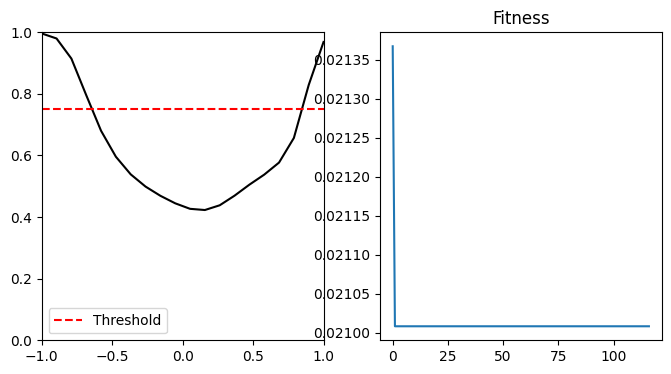

KeyboardInterrupt: 

In [105]:
Robots = GetRobots(N)
Best, FitVector = Genetic(Robots,Plot=True,Plottime=False)
